#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 23
**CH23B Immunization against measles and saving children using the worldbank-immunization dataset**

using the airbnb dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/worldbank-immunization/clean/"
data_out = dirname + "da_case_studies/ch23-immunization-life/"
output = dirname + "da_case_studies/ch23-immunization-life/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
import da_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
# Import data

data = pd.read_csv(data_in + "worldbank-immunization-continents.csv")
# data = pd.read_csv("https://osf.io/58zrj/download")

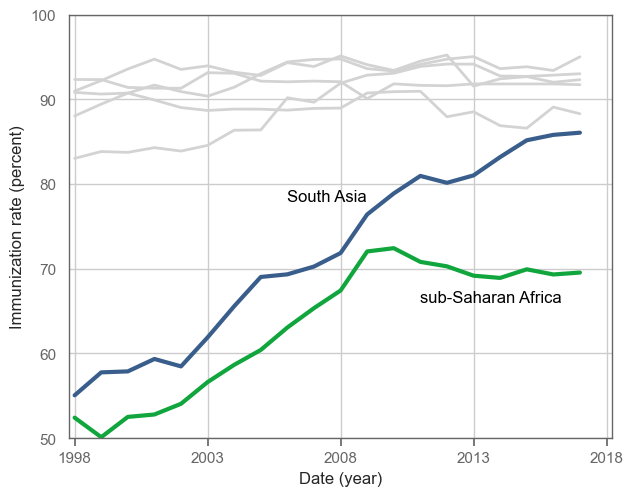

In [5]:
fig, ax = plt.subplots(figsize=(7, 5.5))

# Plot the main lines
sns.lineplot(data=data, x="year", y="imm_SAS", linewidth=3, ax=ax)
sns.lineplot(data=data, x="year", y="imm_SSF", linewidth=3, ax=ax)

# Plot the additional grey lines
for col in data.columns[1:6]:
    sns.lineplot(data=data, x="year", y=col, color="lightgrey", linewidth=2, ax=ax)

# Annotate the specific points
ax.text(2006, 78, "South Asia", fontsize=12)
ax.text(2011, 66, "sub-Saharan Africa", fontsize=12)
# Customize the labels and ticks
ax.set_xlabel("Date (year)")
ax.set_ylabel("Immunization rate (percent)")
ax.set_xticks(np.arange(1998, 2019, 5))
ax.set_yticks(np.arange(50, 101, 10))
ax.set_ylim(50, 100)
ax.set_xlim(1998, 2018)

# Show the plot
da.add_margin(ax, x=0.01, y=0)
plt.show()

In [6]:
data[
    ["surv_EAS", "surv_ECS", "surv_LCN", "surv_MEA", "surv_NAC", "surv_SAS", "surv_SSF"]
] = (
    data[
        [
            "surv_EAS",
            "surv_ECS",
            "surv_LCN",
            "surv_MEA",
            "surv_NAC",
            "surv_SAS",
            "surv_SSF",
        ]
    ]
    / 10
)

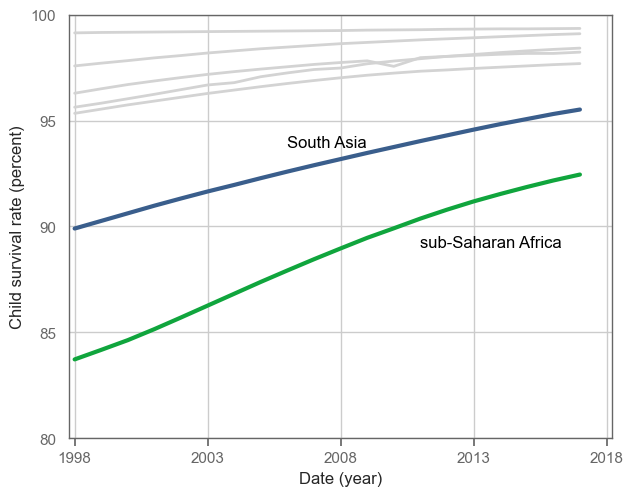

In [7]:
fig, ax = plt.subplots(figsize=(7, 5.5))

# Plot the main lines
sns.lineplot(data=data, x="year", y="surv_SAS", linewidth=3, ax=ax)
sns.lineplot(data=data, x="year", y="surv_SSF", linewidth=3, ax=ax)

# Add additional lines for columns 8 to 13
for col in data.columns[8:13]:
    sns.lineplot(data=data, x="year", y=col, color="lightgrey", linewidth=2, ax=ax)

# Add annotations
ax.text(data.loc[12, "year"] - 4, data.loc[12, "surv_SAS"], "South Asia", fontsize=12)
ax.text(2011, 89, "sub-Saharan Africa", fontsize=12)

# Set labels and title
ax.set_xlabel("Date (year)", fontsize=12)
ax.set_ylabel("Child survival rate (percent)", fontsize=12)

# Set axis limits and ticks
ax.set_xlim(1998, 2018)
ax.set_ylim(80, 100)
ax.set_xticks(np.arange(1998, 2019, 5))
ax.set_yticks(np.arange(80, 101, 5))

da.add_margin(ax, x=0.01, y=0)
plt.show()

# Regressions on countries


In [8]:
data_panel = pd.read_csv(data_in + "worldbank-immunization-panel.csv")
data_panel.describe()

,year,pop,mort,surv,imm,gdppc,lngdppc,hexp
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3642.000000,3642.000000,3165.000000
mean,2007.526924,35.067473,42.982847,95.701715,85.298135,16337.051802,9.042446,6.274914
std,5.759522,132.455594,45.517445,4.551744,15.738758,19070.325200,1.234401,2.878283
min,1998.000000,0.009332,2.100000,75.720000,8.000000,275.518093,5.618653,1.024978
25%,2003.000000,1.756771,9.300000,93.425000,79.000000,3114.288251,8.043756,4.321824
50%,2008.000000,7.395599,23.300000,97.670000,92.000000,9386.069679,9.146982,5.766445
75%,2013.000000,23.576856,65.750000,99.070000,96.000000,22449.101714,10.019005,7.916312
max,2017.000000,1386.395000,242.800000,99.790000,99.000000,124024.568165,11.728235,27.417822


In [9]:
data_panel = data_panel.dropna(subset=["imm", "gdppc"])

In [10]:
data_panel["balanced"] = data_panel["c"].isin(
    data_panel.groupby("c")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1998)&(max_year == 2017)&(n_unique_years==20)")
    .index
)

In [11]:
data_balanced = data_panel.query("balanced == True")

In [12]:
countries_grouped = data_balanced.groupby("c")

data_balanced["lnpop"] = countries_grouped["pop"].transform(np.log)
data_balanced["d_surv"] = countries_grouped["surv"].transform("diff")
data_balanced["d_imm"] = countries_grouped["imm"].transform("diff")
data_balanced["d2_imm"] = countries_grouped["d_imm"].transform("diff")
data_balanced["d_lngdppc"] = countries_grouped["lngdppc"].transform("diff")
data_balanced["d_lnpop"] = countries_grouped["lnpop"].transform("diff")
data_balanced["avgpop"] = countries_grouped["pop"].transform("mean")

data_balanced = data_balanced.sort_values(by=["c", "year"])

## Fixed Effect

In [13]:
fe_lm = pf.feols(
    "surv ~ imm  + C(year) | c",
    data=data_balanced,
    vcov={"CRV1": "c"},
    weights="avgpop",
)
fe_lm2 = pf.feols(
    "surv ~ imm + lngdppc + lnpop  + C(year) | c",
    data=data_balanced,
    vcov={"CRV1": "c"},
    weights="avgpop",
)

### Table 23.2 The effect of measles immunization on child survival. FE regressions

In [14]:
pf.etable([fe_lm, fe_lm2], drop=["year"])

GT(_tbl_data=  level_0               level_1                      0                       1
0    coef                   imm  0.077*** <br> (0.010)   0.038*** <br> (0.011)
1    coef               lngdppc                          1.593*** <br> (0.399)
2    coef                 lnpop                         12.049*** <br> (1.648)
3      fe                     c                      x                       x
4   stats          Observations                   3440                    3440
5   stats             S.E. type                  by: c                   by: c
6   stats         R<sup>2</sup>                  0.959                   0.978
7   stats  R<sup>2</sup> Within                  0.717                   0.848, _body=<great_tables._gt_data.Body object at 0x17372b920>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17372be90>, _spanners=Spanners([SpannerInfo(spanner_id='surv', spanner_level=1, spanner_label='surv', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x168fbd340>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_

In [15]:
# no weights, not in book

fe_lm2_nowts = pf.feols(
    "surv ~ imm + lngdppc + lnpop + C(year) | c", data=data_balanced, vcov={"CRV1": "c"}
)
# large difference in R2
print(fe_lm2_nowts._r2_within)
print(fe_lm2._r2_within)

0.6151025994954717
0.8483654071512511


### Table 23.3 Clustered SE versus biased simple SE in a FE panel regression

In [16]:
fe_lm2_hetero = pf.feols(
    "surv ~ imm + lngdppc + lnpop  + C(year) | c",
    data=data_balanced,
    vcov="iid",
    weights="avgpop",
)

In [17]:
pf.etable([fe_lm2, fe_lm2_hetero], keep=["imm", "lngdppc", "lnpop"])

GT(_tbl_data=  level_0               level_1                       0  \
0    coef                   imm   0.038*** <br> (0.011)   
1    coef               lngdppc   1.593*** <br> (0.399)   
2    coef                 lnpop  12.049*** <br> (1.648)   
3      fe                     c                       x   
4   stats          Observations                    3440   
5   stats             S.E. type                   by: c   
6   stats         R<sup>2</sup>                   0.978   
7   stats  R<sup>2</sup> Within                   0.848   

                        1  
0   0.038*** <br> (0.002)  
1   1.593*** <br> (0.071)  
2  12.049*** <br> (0.227)  
3                       x  
4                    3440  
5                     iid  
6                   0.978  
7                   0.848  , _body=<great_tables._gt_data.Body object at 0x173774ad0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17351ede0>, _spanners=Spanners([SpannerInfo(spanner_id='surv', spanner_level=1, spanner_label='surv', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x17351ea50>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo

## First Difference

In [18]:
data_balanced = data_balanced.reset_index()
data_balanced["year"] = data_balanced["year"].astype("category")

In [19]:
def lag(x: pd.Series, i: int) -> pd.Series:
    return x.shift(i)

In [20]:
basic_fd_formula = "d_surv ~ d_imm"
fd_5_lags_formula = "+".join(
    [basic_fd_formula] + [f"lag(d_imm, {i})" for i in range(1, 6)]
)

In [21]:
fd_lm = pf.feols(
    basic_fd_formula, data=data_balanced, vcov={"CRV1": "c"}, weights="avgpop"
)
fd_lm_5 = pf.feols(
    fd_5_lags_formula, data=data_balanced, vcov={"CRV1": "c"}, weights="avgpop"
)
pf.etable([fd_lm, fd_lm_5])

GT(_tbl_data=   level_0             level_1                      0                      1
0     coef               d_imm  0.009*** <br> (0.002)  0.010*** <br> (0.002)
1     coef       lag(d_imm, 1)                         0.010*** <br> (0.002)
2     coef       lag(d_imm, 2)                         0.011*** <br> (0.002)
3     coef       lag(d_imm, 3)                         0.009*** <br> (0.002)
4     coef       lag(d_imm, 4)                         0.007*** <br> (0.002)
5     coef       lag(d_imm, 5)                          0.006** <br> (0.002)
6     coef           Intercept  0.191*** <br> (0.025)  0.135*** <br> (0.018)
7    stats        Observations                   3268                   2408
8    stats           S.E. type                  by: c                  by: c
9    stats       R<sup>2</sup>                  0.014                  0.081
10   stats  Adj. R<sup>2</sup>                  0.013                  0.079, _body=<great_tables._gt_data.Body object at 0x173562330>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x173560bc0>, _spanners=Spanners([SpannerInfo(spanner_id='d_surv', spanner_level=1, spanner_label='d_surv', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1735621e0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='

In [56]:
fd_lags = "+".join([f"lag(d2_imm,{i})" for i in range(0, 5)])
fd_lags_leads = fd_lags + "+" + "+".join([f"lag(d_imm,{i})" for i in range(-3,0)])

In [57]:
fd_5_lags_cumul = "d_surv ~ lag(d_imm, 5) +" + fd_lags
fd_5_lags_cumul_leads = "d_surv ~ lag(d_imm, 5) +" + fd_lags_leads

In [ ]:
fd_lm_5_cumul = pf.feols(
    fd_5_lags_cumul, data=data_balanced, vcov={"CRV1": "c"}, weights="avgpop"
)
fd_lm_5_cumul_lead = pf.feols(
    fd_5_lags_cumul_leads, data=data_balanced, vcov={"CRV1": "c"}, weights="avgpop"
)
pf.etable([fd_lm_5_cumul, fd_lm_5_cumul_lead], keep="d_imm|d2_imm, -|Intercept")

GT(_tbl_data=  level_0             level_1                      0                      1
0    coef      d_imm.shift(5)  0.054*** <br> (0.009)                       
1    coef       lag(d_imm, 5)                         0.054*** <br> (0.008)
2    coef      lag(d_imm, -3)                           0.005* <br> (0.003)
3    coef      lag(d_imm, -2)                         0.008*** <br> (0.002)
4    coef      lag(d_imm, -1)                         0.009*** <br> (0.002)
5    coef           Intercept  0.135*** <br> (0.018)  0.124*** <br> (0.018)
6   stats        Observations                   2408                   1892
7   stats           S.E. type                  by: c                  by: c
8   stats       R<sup>2</sup>                  0.081                  0.097
9   stats  Adj. R<sup>2</sup>                  0.079                  0.093, _body=<great_tables._gt_data.Body object at 0x1726290a0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17262b860>, _spanners=Spanners([SpannerInfo(spanner_id='d_surv', spanner_level=1, spanner_label='d_surv', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x17262b560>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', v

___

### AGGREG TREND, CONFOUNDERS, CTRY TRENDS

In [25]:
# FD, 5 lags, cumul, aggreg trend

fd_lm_5_cumul_trend_formula = fd_5_lags_cumul + " + C(year)"

fd_lm_5_cumul_trend = pf.feols(
    fd_lm_5_cumul_trend_formula, data=data_balanced, vcov={"CRV1": "c"}, weights="avgpop"
)

In [26]:
# *FD, 5 lags, cumul, aggreg trend, confounders

lngdppc_lags = "+".join([f"lag(d_lngdppc,{i})" for i in range(0, 6)])
lnpop_lags = "+".join([f"lag(d_lnpop,{i})" for i in range(0, 6)])

fd_lm_5_cumul_trend_c_formula = (
    fd_5_lags_cumul + "+" + lngdppc_lags + "+" + lnpop_lags + "+ C(year)"
)
fd_lm_5_cumul_trend_c = pf.feols(
    fd_lm_5_cumul_trend_c_formula,
    data=data_balanced,
    vcov={"CRV1": "c"},
    weights="avgpop",
)

In [27]:
# * check: cumulative coeffs on the confounders

In [28]:
R = (
    fd_lm_5_cumul_trend_c.coef()
    .reset_index()["Coefficient"]
    .str.contains("d_lngdppc")
    .to_numpy()
)

f_test = fd_lm_5_cumul_trend_c.wald_test(R)
print(f_test)

statistic    12.337334
pvalue        0.000444
dtype: float64


In [29]:
R = (
    fd_lm_5_cumul_trend_c.coef()
    .reset_index()["Coefficient"]
    .str.contains("d_lnpop")
    .to_numpy()
)

f_test = fd_lm_5_cumul_trend_c.wald_test(R)
print(f_test)

statistic    5.417664e+01
pvalue       1.832522e-13
dtype: float64


In [30]:
fd_lm_5_cumul_trend_c_country_formula = fd_lm_5_cumul_trend_c_formula + "| c"

fd_lm_5_cumul_trend_c_country = pf.feols(
    fd_lm_5_cumul_trend_c_country_formula,
    data=data_balanced,
    vcov={"CRV1": "c"},
    weights="avgpop",
)

In [31]:
pf.etable(
    [fd_lm_5_cumul_trend, fd_lm_5_cumul_trend_c, fd_lm_5_cumul_trend_c_country],
    keep="d_imm",
)

GT(_tbl_data=  level_0               level_1                      0                      1  \
0    coef         lag(d_imm, 5)  0.053*** <br> (0.010)  0.030*** <br> (0.009)   
1      fe                     c                      -                      -   
2   stats          Observations                   2408                   2408   
3   stats             S.E. type                  by: c                  by: c   
4   stats         R<sup>2</sup>                  0.094                  0.216   
5   stats  R<sup>2</sup> Within                      -                      -   

                       2  
0  0.011*** <br> (0.003)  
1                      x  
2                   2408  
3                  by: c  
4                  0.337  
5                  0.043  , _body=<great_tables._gt_data.Body object at 0x173580290>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x173583260>, _spanners=Spanners([SpannerInfo(spanner_id='d_surv', spanner_level=1, spanner_label='d_surv', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1735800e0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scs